In [11]:
from retry import retry
import requests
import json
import logging
import matplotlib.pyplot as plt
import os
from typing import List
import time
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Diving Deeper

### Picking up 5 relatively distinct large musical genres communities and extract latest 1M comments and their authors


In [1]:
# Definitions
distinct_large_communities = [
    'r/indieheads', 'r/electronicmusic', 'r/hiphopheads', 'r/Metal', 'r/classicalmusic']
days_window = 1
comment_url = "https://api.pushshift.io/reddit/comment/search/"
submission_url = "https://api.pushshift.io/reddit/submission/search/"
blacklisted_users = ['[deleted]', 'AutoModerator']

In [6]:
@retry((requests.exceptions.RequestException, requests.exceptions.Timeout, requests.exceptions.HTTPError, requests.exceptions.ConnectionError, requests.exceptions.JSONDecodeError), delay=5, tries=5)
def throttle_get_request(url, params):
    try:
        response = requests.get(url, params=params)
        data = response.json().get("data", [])
        return data
    except Exception as e:
        logger.warning(
            f"handling bad response. response's status: {response.status_code}")
        raise e

In [7]:
def write_list_to_json_file(data_list, file_path):
    file_size = 0
    if os.path.isfile(file_path):
        file_size = os.stat(file_path).st_size

    with open(file_path, 'ab') as fp:
        if file_size > 0:
            fp.write(b',')
        for item in data_list:
            fp.write(json.dumps(item).encode('utf-8'))
            fp.write(b',')
        fp.seek(-1, os.SEEK_END)
        fp.truncate()
    fp.close()


def read_json_file(file_path):
    with open(file_path, 'r') as fp:
        data = fp.read()
        if data:
            # Remove trailing comma from the file
            if data[-1] == ',':
                data = data[:-1]
            # Load the JSON data into a dictionary
            data_dict = json.loads('[' + data + ']')
        else:
            data_dict = {}
    return data_dict

In [12]:

def fetch_comments_from_subreddits_and_save_to_file(desired_comments_amount: int, subreddits: List[str]):
    desired_keys = ["id", "author", "permalink", "body", "created_utc"]
    for subreddit in subreddits:
        timestamp = int(time.time())
        output_file = f"../data/{subreddit}.json"
        comments = read_json_file(output_file)
        comments_counter = 0
        if comments is not None and len(comments) > 0:
            timestamp = comments[-1]['created_utc']
            comments_counter += len(comments)
        params = {
            "subreddit": subreddit,
            "before": timestamp,
            "size": 1000,
            "sort": "created_utc",
        }
        while comments_counter < desired_comments_amount:
            data = throttle_get_request(comment_url, params)
            if len(data) == 0:
                break
            filtered_comments = [{key: comment.get(key)
                                  for key in desired_keys} for comment in data]
            comments_counter += len(filtered_comments)
            params["before"] = data[-1]['created_utc']
            write_list_to_json_file(
                filtered_comments, output_file)
        logger.info(f"Collected {comments_counter} comments from {subreddit}")


fetch_comments_from_subreddits_and_save_to_file(
    desired_comments_amount=1000000, subreddits=distinct_large_communities)

INFO:__main__:Collected 1219444 comments from r/indieheads
INFO:__main__:Collected 1000813 comments from r/electronicmusic
INFO:__main__:Collected 1000834 comments from r/hiphopheads
INFO:__main__:Collected 1000154 comments from r/Metal
INFO:__main__:Collected 980385 comments from r/classicalmusic


In [13]:
def get_authors_by_commuinity(directory):
    authors = {}
    for filename in os.listdir(directory):
        community_name = filename.split(".")[0]
        authors[community_name] = {}
        if filename.endswith(".json"):
            comments = read_json_file(directory + filename)
            logger.info(
                f'Iterating over {len(comments)} in {community_name} community')
            for comment in comments:
                comment_author = comment['author']
                if authors[community_name].get(comment_author):
                    authors[community_name][comment['author']] += 1
                else:
                    authors[community_name][comment['author']] = 1
            logger.info(
                f'Identified {len(authors[community_name])} authors in {community_name} community')
    return authors


authors = get_authors_by_commuinity('../data/r/')

INFO:__main__:Iterating over 980385 in classicalmusic community
INFO:__main__:Identified 93355 authors in classicalmusic community
INFO:__main__:Iterating over 1000813 in electronicmusic community
INFO:__main__:Identified 147127 authors in electronicmusic community
INFO:__main__:Iterating over 1000834 in hiphopheads community
INFO:__main__:Identified 105576 authors in hiphopheads community
INFO:__main__:Iterating over 1219444 in indieheads community
INFO:__main__:Identified 117145 authors in indieheads community
INFO:__main__:Iterating over 1000154 in Metal community
INFO:__main__:Identified 74055 authors in Metal community


In [14]:
def get_authors_intersections(authors_dict):
    logger.info('Extracting the intersections of authors between communities')
    sets = {community_name: set(community_authors)
            for community_name, community_authors in authors_dict.items()}
    intersections = {}
    total_intersection = set()
    for k1 in sets:
        for k2 in sets:
            if k1 < k2:
                # Get the intersection of the sets corresponding to k1 and k2
                intersection = sets[k1].intersection(sets[k2])
                for blacklisted_user in blacklisted_users:
                    if intersection:
                        intersection.remove(blacklisted_user)

                # Add the intersection to the intersections dictionary
                key = k1 + '_' + k2
                intersections[key] = intersection
                total_intersection.update(intersection)

    for communities_pair in intersections:
        logger.info(
            f'The intersection of {communities_pair} is: [{len(intersections[communities_pair])} authors].')
    return intersections, total_intersection


intersections_by_community, total_intersection = get_authors_intersections(
    authors)

INFO:__main__:Extracting the intersections of authors between communities


INFO:__main__:The intersection of classicalmusic_electronicmusic is: [4006 authors].
INFO:__main__:The intersection of classicalmusic_hiphopheads is: [1286 authors].
INFO:__main__:The intersection of classicalmusic_indieheads is: [2563 authors].
INFO:__main__:The intersection of electronicmusic_hiphopheads is: [4670 authors].
INFO:__main__:The intersection of electronicmusic_indieheads is: [6350 authors].
INFO:__main__:The intersection of hiphopheads_indieheads is: [8270 authors].
INFO:__main__:The intersection of Metal_classicalmusic is: [2643 authors].
INFO:__main__:The intersection of Metal_electronicmusic is: [2876 authors].
INFO:__main__:The intersection of Metal_hiphopheads is: [1802 authors].
INFO:__main__:The intersection of Metal_indieheads is: [2684 authors].


In [16]:
def recreate_authors_without_intersection(authors_dict):
    result = {community.split('/')[1]: {}
              for community in distinct_large_communities}
    for community_name, community_authors in authors_dict.items():
        for author_name, comments_count in community_authors.items():
            if author_name not in total_intersection and author_name not in blacklisted_users:
                result[community_name][author_name] = comments_count
    return result


non_intersection_authors = recreate_authors_without_intersection(authors)

# Picking Up Active Users

Here we'll get the top commenters and plot the distribution of the amount of comments per author


In [17]:
for community_name, community_authors in non_intersection_authors.items():
    non_intersection_authors[community_name] = dict(
        sorted(community_authors.items(), key=lambda item: item[1], reverse=True))
with open('../data/non_intersection_authors.json', 'w') as f:
    json.dump(non_intersection_authors, f)
logger.info(
    'The authors in any community should now be sorted by the amount of comments per author')

INFO:__main__:The authors in any community should now be sorted by the amount of comments per author


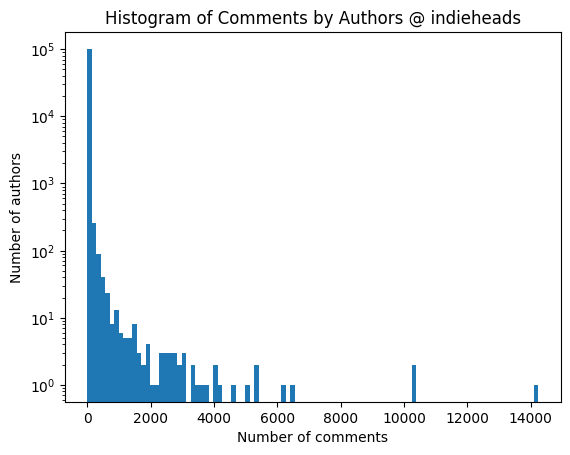

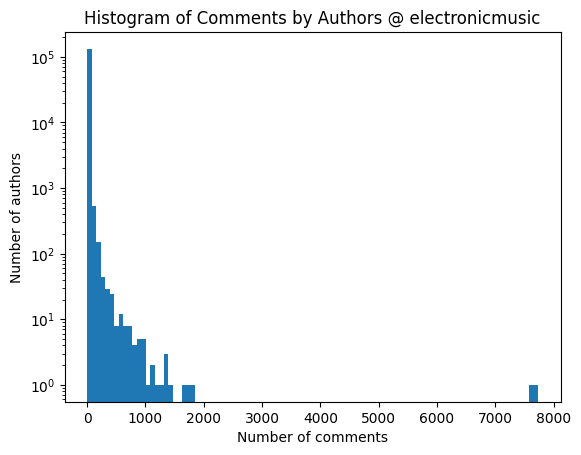

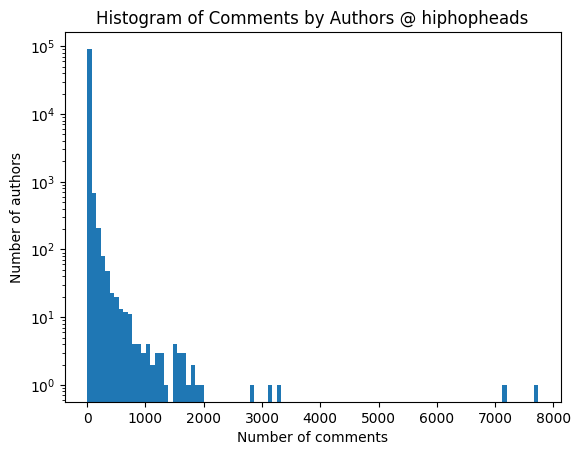

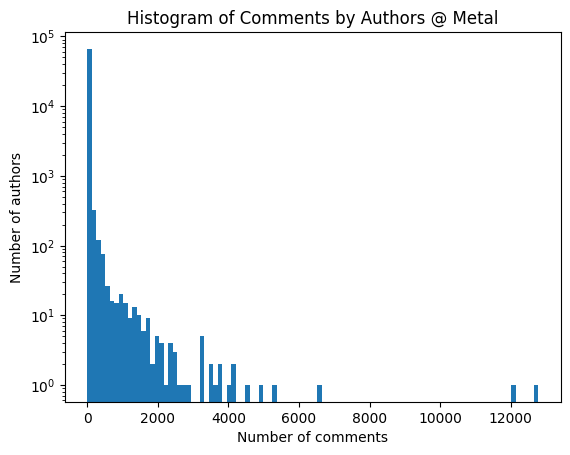

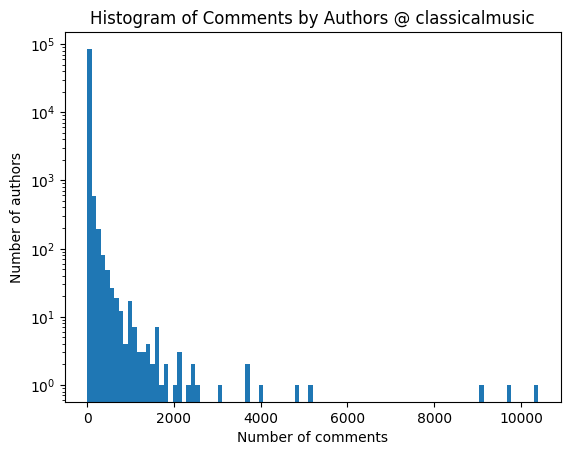

In [16]:
for community_name, community_authors in non_intersection_authors.items():
    values = list(community_authors.values())
    num_bins = 100
    plt.hist(values, bins=num_bins)
    plt.yscale('log')
    plt.xlabel('Number of comments')
    plt.ylabel('Number of authors')
    plt.title(f'Histogram of Comments by Authors @ {community_name}')
    plt.show()

# TOP N Commenters in every community


In [17]:
def get_top_n_commenters(n: int, commenters: dict) -> list:
    sorted_dict = dict(
        sorted(commenters.items(), key=lambda x: x[1], reverse=True))
    return list(sorted_dict.items())[:n]


top_commenters_by_community = {}
comment_amounts = [500, 1000, 2000]
for community_name, community_authors in non_intersection_authors.items():
    for amount in comment_amounts:
        top_n_commenters = get_top_n_commenters(
            n=amount, commenters=community_authors)
        print(
            f"{community_name} | {amount}th commenter --> {top_n_commenters[amount-1]}")
        if amount == 1000:
            top_commenters_by_community[community_name] = [
                commenter[0] for commenter in top_n_commenters]
    print('----')

indieheads | 500th commenter --> ('johancolli', 143)
indieheads | 1000th commenter --> ('dubrovnique', 78)
indieheads | 2000th commenter --> ('MaunShcAllister', 41)
----
electronicmusic | 500th commenter --> ('Dysphoriography', 111)
electronicmusic | 1000th commenter --> ('God_I_Suck', 70)
electronicmusic | 2000th commenter --> ('kaydpea', 44)
----
hiphopheads | 500th commenter --> ('RyVsWorld', 145)
hiphopheads | 1000th commenter --> ('beerrabbit124', 87)
hiphopheads | 2000th commenter --> ('Killthomas7', 51)
----
Metal | 500th commenter --> ('maximusfpv', 179)
Metal | 1000th commenter --> ('BillyTalentfan', 88)
Metal | 2000th commenter --> ('thrashinbatman', 45)
----
classicalmusic | 500th commenter --> ('felixou98', 191)
classicalmusic | 1000th commenter --> ('throwawayAcc16777216', 109)
classicalmusic | 2000th commenter --> ('TheQueefGoblin', 58)
----


# Commenters that posted more than Y comments in every community


In [18]:
comment_amounts = [50, 200, 500, 1000]
for community_name, community_authors in non_intersection_authors.items():
    for amount in comment_amounts:
        sorted_commenters = sorted(
            community_authors.items(), key=lambda x: x[1], reverse=True)
        top_list = [
            commenter for commenter in sorted_commenters if commenter[1] >= amount]
        print(f"{community_name} | Y={amount} --> {len(top_list)} commenters with {amount} or more comments")
    print('----')

indieheads | Y=50 --> 1646 commenters with 50 or more comments
indieheads | Y=200 --> 354 commenters with 200 or more comments
indieheads | Y=500 --> 136 commenters with 500 or more comments
indieheads | Y=1000 --> 69 commenters with 1000 or more comments
----
electronicmusic | Y=50 --> 1642 commenters with 50 or more comments
electronicmusic | Y=200 --> 194 commenters with 200 or more comments
electronicmusic | Y=500 --> 60 commenters with 500 or more comments
electronicmusic | Y=1000 --> 15 commenters with 1000 or more comments
----
hiphopheads | Y=50 --> 2059 commenters with 50 or more comments
hiphopheads | Y=200 --> 319 commenters with 200 or more comments
hiphopheads | Y=500 --> 90 commenters with 500 or more comments
hiphopheads | Y=1000 --> 35 commenters with 1000 or more comments
----
Metal | Y=50 --> 1799 commenters with 50 or more comments
Metal | Y=200 --> 468 commenters with 200 or more comments
Metal | Y=500 --> 186 commenters with 500 or more comments
Metal | Y=1000 --> 